In [220]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as aconst
from calcwf import shifted_f, shifted_e, P_from_f, num_orbits, peri_advance_orbit, gen_wf, get_h, trim_wf, chirp2total, get_h, overlap_cplx_wfs, match_wfs

# Generate training data

In [95]:
# Generates n training waveforms equally spaced in true anomaly
def gen_training_wfs(f_low, e, M, q, n, sample_rate, approximant):

    # Check if both h_ap and h_peri included
    if n%2 == 1:
        print('Both h_ap and h_peri are included only if an even number of training waveforms are requested.')

    # Generate shifted frequency, eccentricity, phase values
    max_s_f = shifted_f(f_low, e, M, q)
    s_f_vals = np.linspace(f_low, max_s_f, n, endpoint=False)
    s_e_vals = shifted_e(s_f_vals, f_low, e)

    training_wfs = []
    # Generate all training waveforms
    for i, (s_f, s_e) in enumerate(zip(s_f_vals, s_e_vals)):

        # Create waveform
        h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=0)

        # Trim waveform to same size as first (shortest), and corrects phase
        if i > 0:
            h = trim_wf(h, training_wfs[0])
            overlap = overlap_cplx_wfs(h, training_wfs[0], f_low)
            phase_angle = +np.angle(overlap)/2
            h = gen_wf(s_f, s_e, M, q, sample_rate, approximant, phase=phase_angle)
            h = trim_wf(h, training_wfs[0])
            
        training_wfs.append(h)

        # Progress bar
        print(f'\r{i+1} done out of {n}.', end='')

    return training_wfs

In [99]:
training_wfs = gen_training_wfs(10, 0.1, chirp2total(24, 2), 2, 100, 4096, 'TEOBResumS')

100 done out of 100.

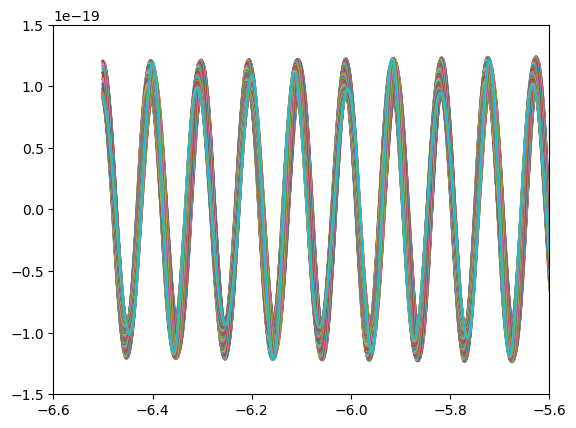

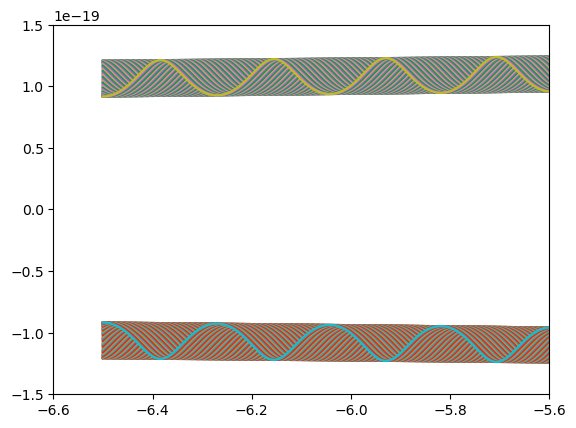

In [113]:
for i, wf in enumerate(training_wfs):
    plt.plot(wf.sample_times, wf)
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

for i, wf in enumerate(training_wfs):
    plt.plot(wf.sample_times, np.sqrt(wf.real()**2+wf.imag()**2))
    plt.plot(wf.sample_times, -np.sqrt(wf.real()**2+wf.imag()**2))
plt.xlim(-6.6,-5.6)
plt.ylim(-1.5e-19,1.5e-19)
plt.show()

# Performing PCA

In [141]:
# Convert training wf data to np array in right shape/form and calc svd
X = np.array(training_wfs).T
means = X.mean(axis=0) 
stds = X.std(axis=0) 
_, s, pcs = np.linalg.svd((X-means)/stds)

# PCA results

Relative importance of ith direction is given by:

\begin{equation}
\frac{S_i^2}{\Sigma S_i^2}
\end{equation}

Coefficients of xth waveform for each direction are given by pcs.T[x]. All of the coefficents in the yth direction are therefore given by pcs[y].

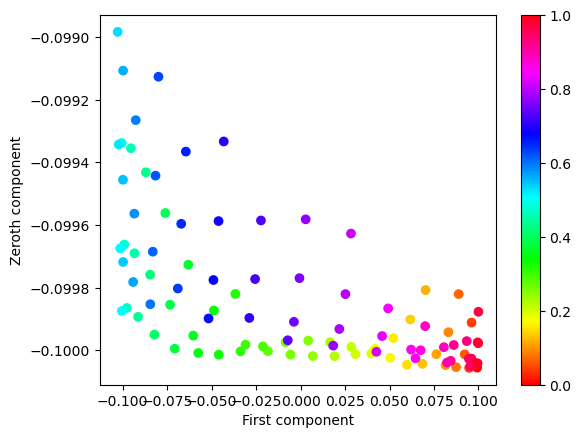

In [203]:
# Plot of real parts of zeroth, first directions
colors = np.linspace(0,1,100,endpoint=False)
plt.scatter(np.real(pcs[1]), np.real(pcs[0]), c=colors, vmin=0, vmax=1, cmap='hsv')
plt.xlabel('First component')
plt.ylabel('Zeroth component')
plt.colorbar()

See that real part of zeroth component is always very close to -0.1. Turns out imaginary part is also always v. close to 0. Real part of first component is positive for h_peri (i.e. opposite to zeroth component), and negative for h_ap (i.e. opposite to first component). This is consistent with our current picture of zeroth/first components being h1/h2, as h_peri = h_1 - h_2 and h_ap = h_1 + h_2. Overall negative sign above is arbitrary and can be switched by simply changing phase by pi.

Now plot complex values of first component only (as zeroth component seems to be almost exactly -0.1+0j by construction).

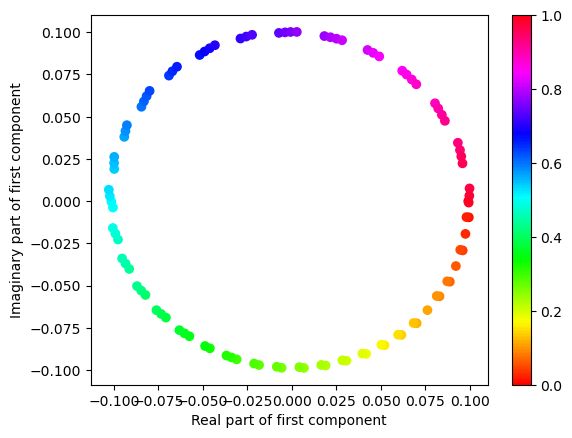

In [205]:
# Plot of complex parts of first direction
colors = np.linspace(0,1,100,endpoint=False)
plt.scatter(np.real(pcs[1]), np.imag(pcs[1]), c=colors, vmin=0, vmax=1, cmap='hsv')
plt.xlabel('Real part of first component')
plt.ylabel('Imaginary part of first component')
plt.colorbar()

Can very clearly see that as true anomaly is changed over 2pi, the first component rotates around a complete circle in complex space.

Now look at S matrix to check relative importance of each component.

In [212]:
rel_imports = []
for i in range(5):
    rel_imports.append(s[i]**2/np.sum(s**2))
    print('Component {} contains {:.2f}% of the total information.'.format(i, rel_imports[i]*100))

print('\n')
print('Components 0 and 1 combined contain {:.2f}% of the total information.'.format((rel_imports[0]+rel_imports[1])*100))

Component 0 contains 96.73% of the total information.
Component 1 contains 2.60% of the total information.
Component 2 contains 0.59% of the total information.
Component 3 contains 0.05% of the total information.
Component 4 contains 0.02% of the total information.


Components 0 and 1 combined contain 99.33% of the total information.


Can see that for $e_{10} = 0.1$, $\mathcal{M} = 24 M_\odot$, $q=2$, the first two components alone contain 99.3% of the total information. The model therefore seems to be quite a good approximation in this region of parameter space. By repeating this for different parameter choices, we could see in which regions this model would break down.

The first two components here are consistent with being h1 and h2 respectively, however this is not proven to be the case. In order to prove these, should plot combinations of h1 and h2 using these coefficients and check against original waveforms.

# h1, h2 comparison

In [238]:
# Plots and compares match between training waveform and combination of h1 and h2 waveforms
def compare_wfs(training_wf, h1_h2_comps, f_low, e, M, q, sample_rate, approximant):

    # Generate h from h1, h2 components
    h, _, _, _, _ = get_h(h1_h2_comps, f_low, e, M, q, sample_rate, approximant=approximant)

    # Calculate match between waveforms
    m = match_wfs(training_wf, h, 10, True)
    print(f'Match of {np.abs(m)}')

    # Plot both real waveforms
    plt.plot(training_wf.sample_times, training_wf.real(), label='Training wf')
    plt.plot(h.sample_times, h.real(), label='From h1, h2 components')
    plt.title('Real')
    plt.xlim(-7,-5)
    plt.legend() 
    plt.show()

    # Plot both imaginary waveforms
    plt.plot(training_wf.sample_times, training_wf.imag(), label='Training wf')
    plt.plot(h.sample_times, h.imag(), label='From h1, h2 components')
    plt.title('Imaginary')
    plt.xlim(-7,-5)
    plt.legend()
    plt.show()

    # Plot both waveform envelopes
    plt.plot(training_wf.sample_times, np.sqrt(training_wf.real()**2+training_wf.imag()**2), c='C0', label='Training wf')
    plt.plot(training_wf.sample_times, -np.sqrt(training_wf.real()**2+training_wf.imag()**2), c='C0')
    plt.plot(h.sample_times, np.sqrt(h.real()**2+h.imag()**2), c='C1', label='From h1, h2 components')
    plt.plot(h.sample_times, -np.sqrt(h.real()**2+h.imag()**2), c='C1')
    plt.title('Envelopes')
    plt.xlim(-7,-5)
    plt.legend()
    plt.show()

First plot h_ap training waveform (i.e. the first training waveform), and use the h1, h2 components from the pca/svd above. Will multiply these components by (-10,10) first in order to get roughly same scale (and right sign). Can do this as match function does not care about amplitude or phase. Can multiple each component by opposite sign as can choose/postulate that directions from pca/svd actually correspond to e.g. -h1, +h2.

[(1.0005508489509298-0j), (0.9925426911739716+0j)]
1.9930935401249015
Match of 0.9993458202684504


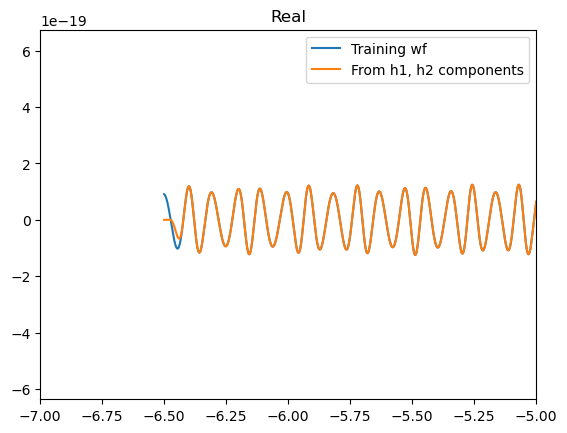

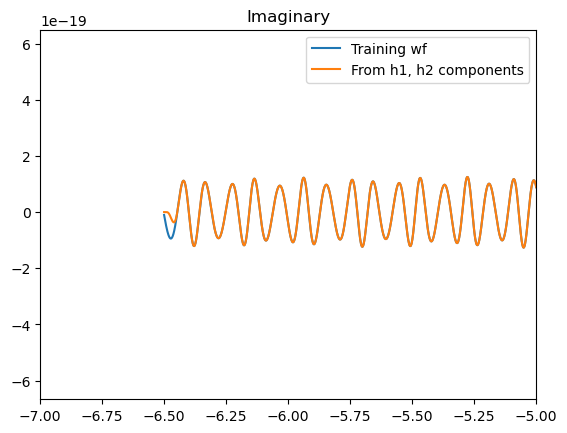

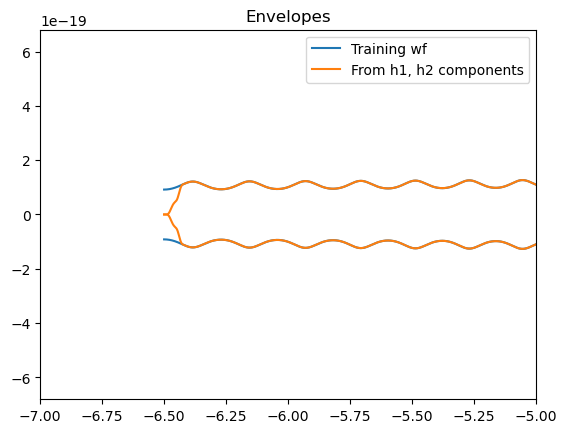

In [255]:
components = [-10*pcs[0][0], 10*pcs[1][0]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[0], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

Looks very good! Now try for h_peri (50th training waveform), as well as a few others.

[(0.9987404983474524+0.04905619321649745j), (-1.0048043572053098-0.038091906219186816j)]
2.005470670784636
Match of 0.9987597845489095


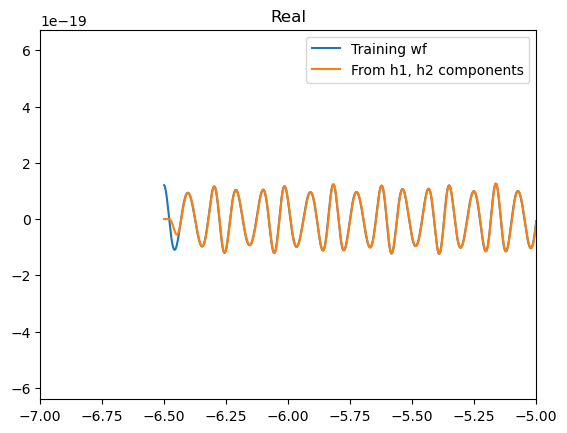

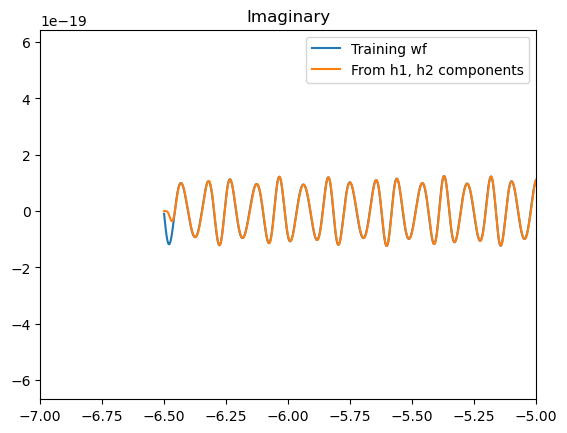

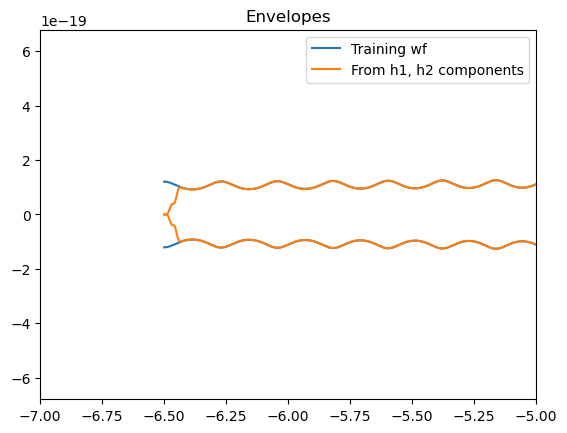

In [254]:
components = [-10*pcs[0][50], 10*pcs[1][50]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[50], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

[(0.9996877786666747+0.037693020017710445j), (0.04296918439945173-0.9833655662327754j)]
1.9847020402458484
Match of 0.9967765994346343


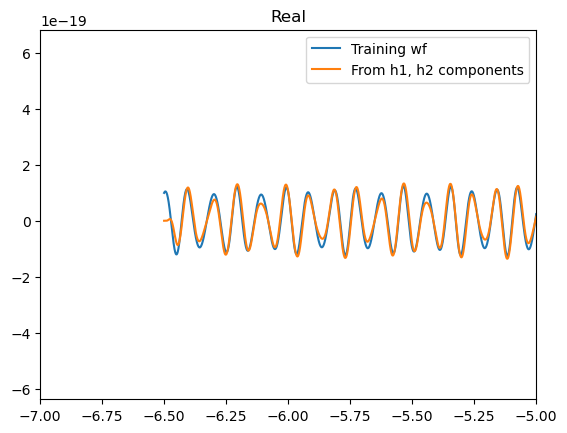

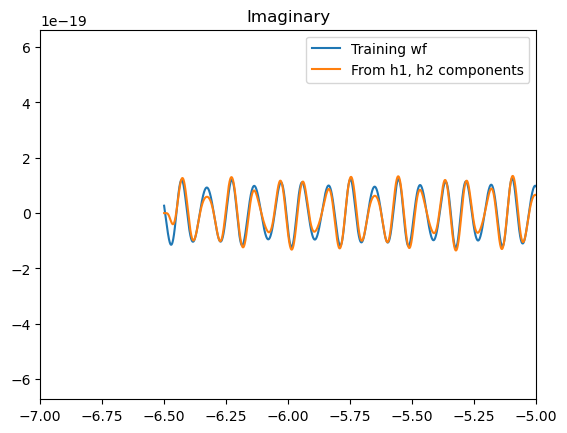

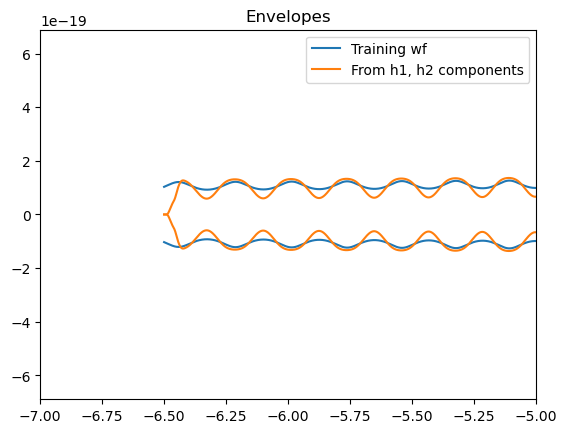

In [261]:
components = [-10*pcs[0][25], 10*pcs[1][25]]
print(components)
print(np.sum(np.abs(components)))
compare_wfs(training_wfs[25], components, 10, 0.1, chirp2total(24, 2), 2, 4096, 'TEOBResumS')

This appears to be where the 0.7% of information lost by keeping only the first two components comes into play.